# Training pretrained ResNet50 model on The oxford flowers 102 dataset 

In this project, there are three libraries needed. And have been imported into the cell below.

In [67]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### Checking GPU 

I ran this notebook on Kaggle's notebooks code editor.

In [68]:
!nvidia-smi

Wed Aug 23 10:01:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    36W / 250W |  16111MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

 ### Loading the data from tensorflow_datasets

This API has lots of datasets that can be used to train or develop models. you can check them out at https://www.tensorflow.org/datasets/catalog/overview#all_datasetsnotebooks.


In [69]:
datasets_list = tfds.list_builders()
data_name = 'oxford_flowers102'
try:
  (train, test), info = tfds.load(name=data_name,
                            split=['train', 'validation'],
                            as_supervised=True,
                            with_info=True)
except ImportError:
  print(f'The dataset {data_name} is not available!')

The label of the following image is 72


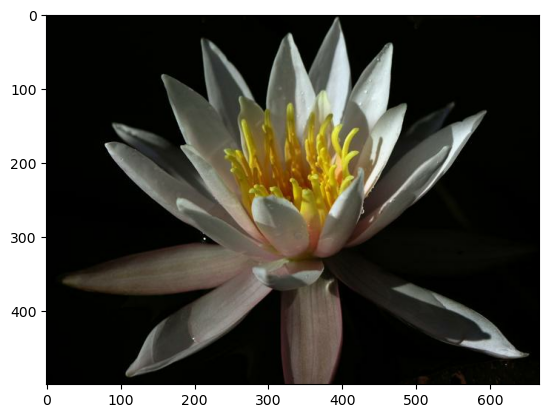

The label of the following image is 84


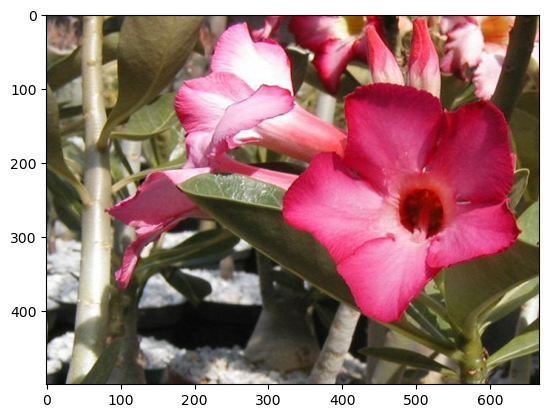

The label of the following image is 70


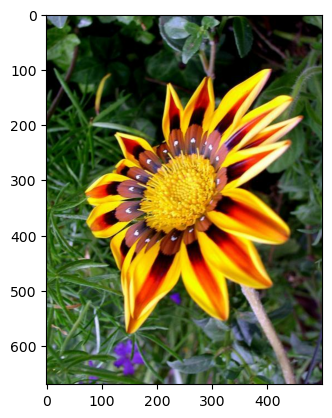

The label of the following image is 51


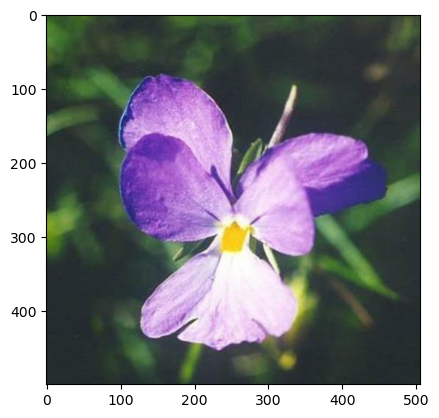

The label of the following image is 48


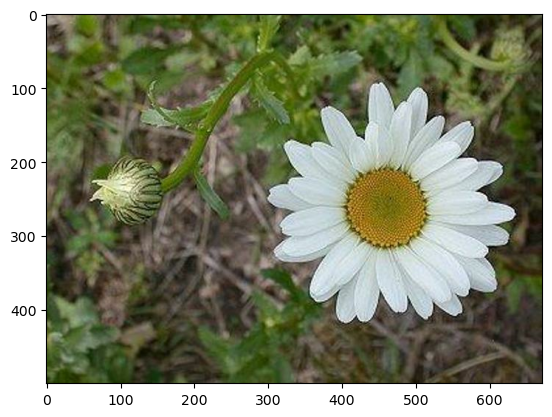

In [70]:
train_image = train.take(5)

for image, labels in train_image:
  plt.imshow(image)
  print(f'The label of the following image is {labels.numpy()}')
  plt.show()

### Resizing the images

The images must have similiar width and length. In order to process faster I put it down on 300 by 300 px. 

In [71]:
def resize_image(image, label, size=[300, 300]):
    print("Original image shape:", image.shape)
    image = tf.image.resize(image, size)
    print("Resized image shape:", image.shape)
    return image, label

In [72]:
train = train.map(map_func=resize_image, num_parallel_calls=tf.data.AUTOTUNE)
train = train.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test = test.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
test = test.batch(32).prefetch(tf.data.AUTOTUNE)

Original image shape: (None, None, 3)
Resized image shape: (300, 300, 3)
Original image shape: (None, None, 3)
Resized image shape: (300, 300, 3)


## Model

My approach is using transfer learning and a famous pretrained model called ResNet50.

ResNet-50 (Residual Network 50) is a deep convolutional neural network architecture that addresses the challenge of training very deep networks by introducing residual connections, also known as skip connections. It was introduced by Kaiming He et al. in the paper "Deep Residual Learning for Image Recognition" in 2015 and has been widely adopted for various computer vision tasks.

The core innovation of ResNet-50 lies in its residual blocks. Each residual block consists of several convolutional layers and introduces a "shortcut" connection that bypasses one or more layers, allowing the network to learn residual functions rather than raw features. This is achieved by adding the output of a previous layer to the output of a subsequent layer, effectively allowing the network to learn the difference between the two. These residual connections enable the training of very deep networks without suffering from vanishing gradients, making it easier to optimize and improving performance.

ResNet-50 specifically comprises 50 layers, including convolutional, batch normalization, and activation layers, as well as pooling and fully connected layers for classification. The architecture is divided into several stages, each with its own set of residual blocks. The initial stage performs basic convolution and pooling operations to extract low-level features. Subsequent stages gradually increase the number of filters and the complexity of learned features.

The overall architecture of ResNet-50 can be summarized as follows:
1. Input layer: Accepts the input image.
2. Convolutional and pooling layers: Initial layers perform basic feature extraction and dimensionality reduction.
3. Residual stages: Each stage consists of multiple residual blocks. The number of blocks increases as you move deeper into the network.
4. Global average pooling: Reduces the spatial dimensions of the features to a fixed size.
5. Fully connected layers: Produce the final classification output.

ResNet-50 has significantly advanced the field of deep learning by enabling the training of deeper networks, which has led to improved accuracy on various image recognition benchmarks. Its architectural ideas, particularly the use of residual connections, have influenced the design of subsequent neural network architectures and continue to be an important foundation for modern computer vision research.

While creating the model for this project, I have frozen the most layers except the last 25. then added 2 fully connected dense layer to the end of the model.

In [73]:
class PretrainedModel:
  def __init__(self, input_shape=(300, 300, 3), base_model_name='ResNet50'):
    self.input_shape = input_shape
    self.base_model = getattr(tf.keras.applications, base_model_name)(include_top=False)
    self.base_model.trainable = False
    for layer in self.base_model.layers[-25:]:
        layer.trainable = True

  def build_model(self):
    input = tf.keras.layers.Input(shape=self.input_shape, name='input_shape')
    x = self.base_model(input)
    x = tf.keras.layers.GlobalMaxPooling2D(name='Global_Average_pooling')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(2048, activation='relu', name='Dense_layer_1')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(102, activation='softmax', name='Dense_layer_2')(x)
    model = tf.keras.Model(input, output)

    return model

In [74]:
pt = PretrainedModel()
model = pt.build_model()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

Each layer used behind the ResNet50 can be seen below

In [75]:
for index, layers in enumerate(pt.base_model.layers):
    print(index, layers.name)

0 input_5
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [76]:
pt.base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [77]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 300, 300, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 Global_Average_pooling (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 Dense_layer_1 (Dense)       (None, 2048)              4196352   
                                                                 
 dropout_11 (Dropout)        (None, 2048)              0         
                                                           

### Callbacks 

In [78]:
callback_path = 'transfer_learning_callbacks/'
checkpoint_path = 'checkpoint_callback.ckpt'
tensorboard_path = 'tensorboard/'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=callback_path+checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=callback_path+tensorboard_path)

### Fitting the model

In [79]:
history = model.fit(train,
                    epochs=50,
                    steps_per_epoch=len(train),
                    validation_data=test,
                    validation_steps=int(0.3 * len(test)),
                    callbacks=[checkpoint_callback, tensorboard_callback])

Epoch 1/50
32/32 [==============================] - 13s 207ms/step - loss: 33.1467 - accuracy: 0.0235 - val_loss: 4.7642 - val_accuracy: 0.0903
Epoch 2/50
32/32 [==============================] - 8s 179ms/step - loss: 4.6314 - accuracy: 0.0578 - val_loss: 4.2063 - val_accuracy: 0.1111
Epoch 3/50
32/32 [==============================] - 8s 171ms/step - loss: 4.1497 - accuracy: 0.1029 - val_loss: 3.8857 - val_accuracy: 0.1458
Epoch 4/50
32/32 [==============================] - 8s 168ms/step - loss: 3.8462 - accuracy: 0.1402 - val_loss: 3.4712 - val_accuracy: 0.2188
Epoch 5/50
32/32 [==============================] - 8s 182ms/step - loss: 3.4483 - accuracy: 0.2157 - val_loss: 3.1001 - val_accuracy: 0.2882
Epoch 6/50
32/32 [==============================] - 8s 178ms/step - loss: 3.1341 - accuracy: 0.2451 - val_loss: 2.7471 - val_accuracy: 0.3229
Epoch 7/50
32/32 [==============================] - 8s 181ms/step - loss: 2.8124 - accuracy: 0.2961 - val_loss: 2.2852 - val_accuracy: 0.4444
Epoc

Val_accuracy for the training is about 76% and for the test 72%. It can be improved.

In [80]:
predict = model.evaluate(test)

32/32 [==============================] - 4s 119ms/step - loss: 0.9977 - accuracy: 0.7265


### Visuallizing the result


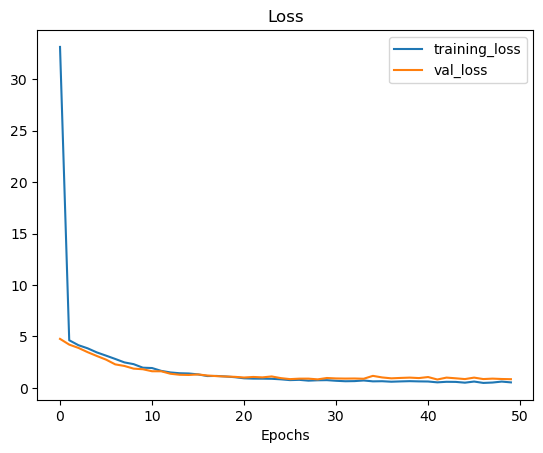

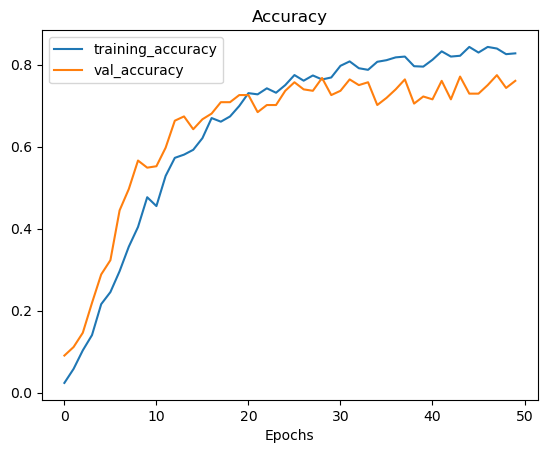

In [81]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

### Tensorboard Callback
The following code returns a tensorboard in order to check the training and validation process of the model

In [ ]:
log = callback_path + tensorboard_path 
!load_ext tensorboard
!tensorboard dev upload --logdir log

/bin/bash: line 1: load_ext: command not found
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system